In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Setup

Necessary imports and helper functions for displaying points, boxes, and masks.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In addition, a Model Checkpoint needs to be downloaded. This can be done on Meta's SAM github: https://github.com/facebookresearch/segment-anything#model-checkpoints

## Sequential Renaming of Folder

Run following two blocks if you haven't before, renames each image in folder to a number sequentially

In [3]:
# Set path for desired image sequence
dir = r"c:\Users\jyl772\Desktop\tmg"

In [4]:
import os
os.getcwd()
for i, filename in enumerate(os.listdir(dir)):
    if filename != str(i) + '.tif':
        os.rename(dir + '//' + filename,dir + '//' + str(i) + '.tif')

In [8]:
# Sort folder into an ordered list
import glob
import re
import os

images=[]
count = 0
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split('(\d+)', s)]

for image in sorted(glob.glob(dir + '\*.tif'),key = natsort):
    img = cv2.imread(image)
    images.append(img)

## Set SAM Checkpoint

Load the SAM model and predictor. Change the path below to point to the SAM checkpoint.

In [9]:
import sys
sys.path.append(r"c:\Users\jyl772\Desktop\sam_vit_h_4b8939.pth") # Change path here to point to SAM Model Checkpoint
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

predictor = SamPredictor(sam)

Display of first image in folder. Note the coordinate system for future reference.

(-0.5, 629.5, 2087.5, -0.5)

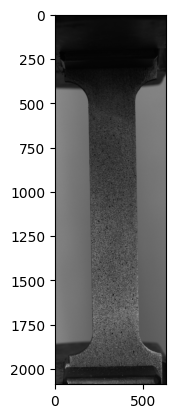

In [10]:
plt.imshow(images[0])
plt.axis('on')

## Segmentation

In the block below, choose a point on the image at which you want segmented.

For example: 

    input_point = np.array([[50,100]])
    input_label = np.array([1])

This would set one point on the image at (50,100) and highlight the predicted segment.

Also:

    input_point = np.array([[50,100],[100,200]])
    input_label = np.array([1,1])

This would choose two points and run the same prediction model.



For each image, the model will display three different segment predictions. You may choose the best one and save only that number into your output folder.


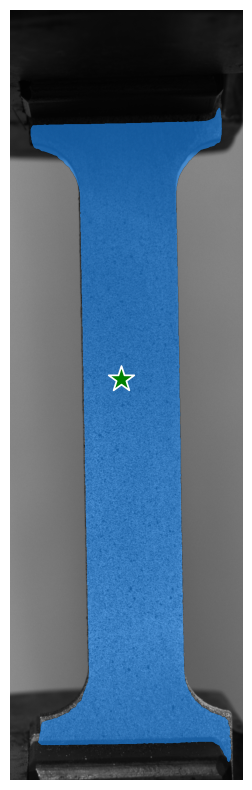

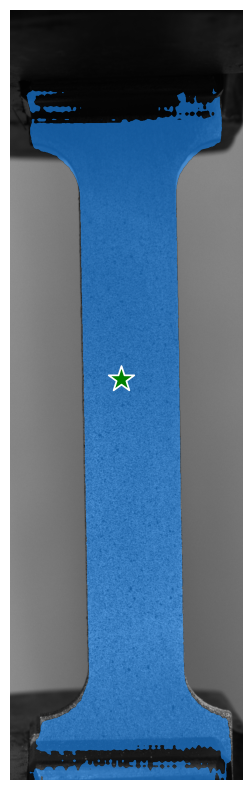

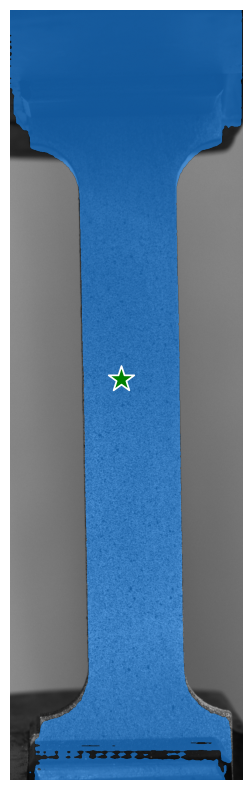

In [11]:
# Change the number after image (bracketed) to choose different images within your input folder
predictor.set_image(images[0])
    
# Set coordinate and number of points for segmentation
input_point = np.array([[300,1000]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(
point_coords=input_point,
point_labels=input_label,
multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(images[80]) # Change number here as well
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.axis('off')

Note which number provides the best segmentation results, it can be chosen in the next block. Top image is 0, middle image is 1, bottom image is 2.

Feel free to run multiple images to confirm your choice.

This next block iterates over the entire image sequence. Make sure to choose the correct number to save only the desired mask files.

This will run for a long time (about 30-45 seconds per image). 

In [12]:
# Declare which image you would like to move forward with (0,1, or 2)

best_img = 0

In [13]:
# Output folder Path
# Folder should already exist

output = r'c:\Users\jyl772\Desktop\tmg_output'

Make sure to set input_point and input_label again

In [17]:
count = 0 
for image in images[0:]: # This number can be changed to set a range of images that you would like processed; "count" should also be changed for file naming purpose
    predictor.set_image(image)

    input_point = np.array([[300,1000]])
    input_label = np.array([1])

    masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
    )

    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        plt.axis('off')
        if i == best_img:
            plt.savefig(output + '\image'+str(count)+'mask'+str(i)+'.tif')
    
    count += 1

C:\Users\jyl772\AppData\Local\Temp\ipykernel_14640\2629258869.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,10))


KeyboardInterrupt: 

After the for loop is done running, you may notice a few bad frames. You can always go back and check the three different possible outputs for each individual image and change the image number (0,1,2) to reflect the best image. The range of the for loop can be changed to run select images again.